In [1]:
import scanpy as sc
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scvi
import torch
from ray import tune
from scvi import autotune

/home/sapien/anaconda3/envs/integ/lib/python3.10/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

In [3]:
print(f"scVI version: {scvi.__version__}")

scVI version: 1.3.1.post1


In [4]:
adata = sc.read('unintigrated.h5ad')
adata

AnnData object with n_obs × n_vars = 58015 × 18505
    obs: 'samples', 'condition', 'location', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'low_label', 'low_score'

In [5]:
sc.pp.filter_genes(adata, min_cells = 100)
adata

AnnData object with n_obs × n_vars = 58015 × 14469
    obs: 'samples', 'condition', 'location', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'low_label', 'low_score'
    var: 'n_cells'

In [8]:
scvi.model.SCVI.setup_anndata(adata,
                              categorical_covariate_keys = ['samples'],
                             continuous_covariate_keys=['pct_counts_mt', 'pct_counts_ribo'])

In [ ]:
model = scvi.model.SCVI(adata, n_hidden = 256, n_latent = 60 , n_layers = 1 , gene_likelihood = 'nb')

In [ ]:
kwargs = {'lr': 0.0065}

In [ ]:
#model.train(max_epochs = 200, early_stopping = True, plan_kwargs = kwargs)

In [9]:
model = scvi.model.SCVI.load('the_model/', adata)

INFO     File the_model/model.pt already downloaded                                                                


In [10]:
y = model.history['reconstruction_loss_validation']['reconstruction_loss_validation'].min()

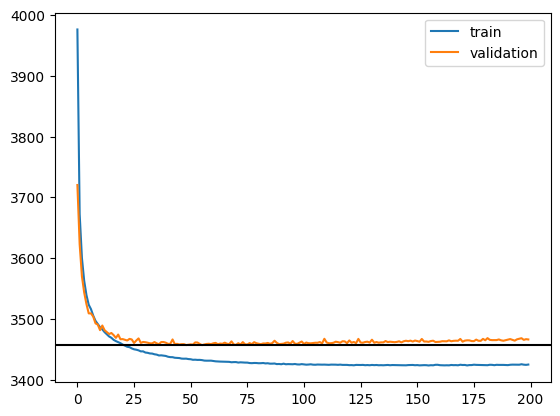

In [11]:
plt.plot(model.history['reconstruction_loss_train']['reconstruction_loss_train'], label='train')
plt.plot(model.history['reconstruction_loss_validation']['reconstruction_loss_validation'], label='validation')

plt.axhline(y, c = 'k')

plt.legend()
plt.show()

In [12]:
#adata.write_h5ad('temp.h5ad')

In [13]:
adata.obsm['X_scVI'] = model.get_latent_representation()

In [14]:
adata.obsm['X_scVI'].shape

(58015, 60)

In [15]:
sc.pp.neighbors(adata, use_rep='X_scVI', )

In [16]:
sc.tl.leiden(adata, resolution = 3, key_added = 'overcluster')

In [17]:
sc.tl.umap(adata)

In [18]:
adata.layers['counts'] = adata.X.copy()

In [20]:
sc.pp.normalize_total(adata)


In [21]:
sc.pp.log1p(adata)

In [22]:
adata.write_h5ad('temp.h5ad')

In [23]:
adata.obs['low_major'] = adata.obs.groupby('overcluster')['low_label'].transform(lambda x: x.mode()[0])

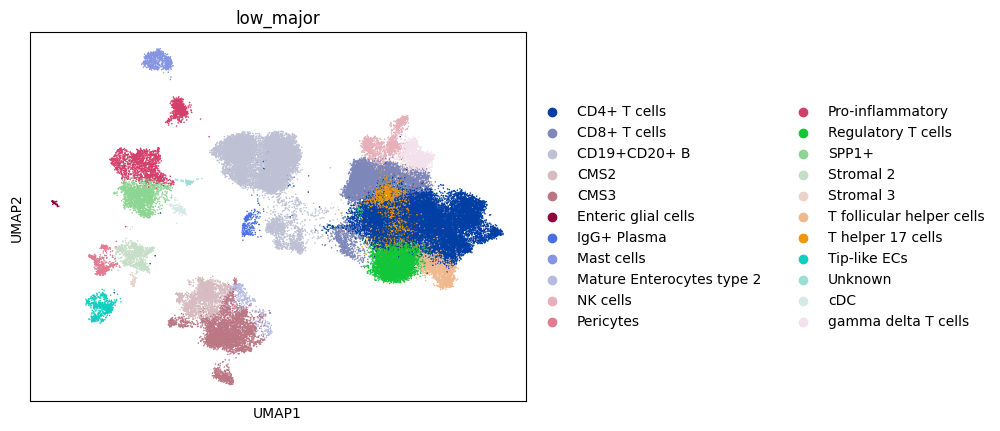

In [24]:
sc.pl.umap(adata, color = ['low_major'], s = 5)

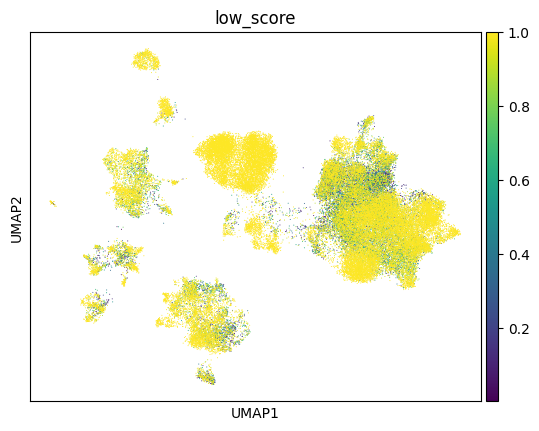

In [25]:
sc.pl.umap(adata, color = ['low_score' ])

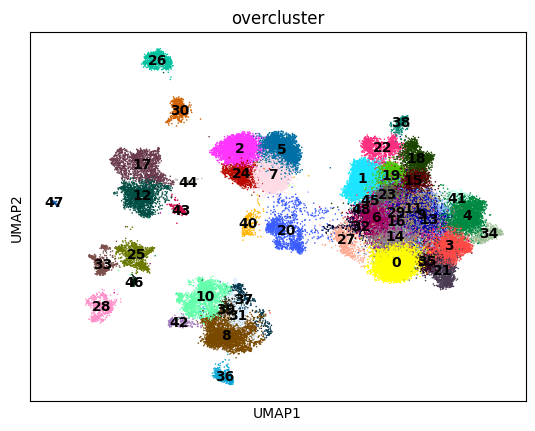

In [26]:
sc.pl.umap(adata, color = ['overcluster'], legend_loc = 'on data', s = 5)

In [27]:
adata.obs

,samples,condition,location,n_genes,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,pct_counts_mt,pct_counts_ribo,pct_counts_hb,low_label,low_score,_scvi_batch,_scvi_labels,overcluster,low_major
711_AAACCCAAGTCGGGAT-1,711,Tumor,Right,707,707,6.562444,1396.0,7.242083,26.862464,10.100286,25.716331,0.000000,T follicular helper cells,0.103311,0,0,14,CD4+ T cells
711_AAACCCACAGAGGAAA-1,711,Tumor,Right,838,838,6.732211,1504.0,7.316548,23.803191,9.441490,13.962767,0.000000,Unknown,0.236022,0,0,11,CD4+ T cells
711_AAACCCACATGATAGA-1,711,Tumor,Right,435,435,6.077642,613.0,6.419995,17.781403,0.815661,18.270800,0.000000,Unknown,0.400460,0,0,36,CMS3
711_AAACCCAGTCTCGCGA-1,711,Tumor,Right,579,579,6.363028,860.0,6.758094,23.255814,15.465117,6.395349,0.000000,Tip-like ECs,0.966648,0,0,28,Tip-like ECs
711_AAACGAAGTTATCTTC-1,711,Tumor,Right,1384,1384,7.233455,2629.0,7.874739,19.246862,8.178015,15.405098,0.000000,gamma delta T cells,0.993837,0,0,15,CD8+ T cells
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706_TTTGGTTCAAACACCT-1,706,Tumor,Left,1815,1815,7.504392,4944.0,8.506132,21.318770,1.961974,21.318771,0.020227,CD8+ T cells,0.999997,0,0,1,CD8+ T cells
706_TTTGGTTCAACGGGTA-1,706,Tumor,Left,909,909,6.813445,3528.0,8.168770,34.722222,0.368481,25.368483,0.000000,Pro-inflammatory,0.549964,0,0,12,SPP1+
706_TTTGGTTTCTATCGCC-1,706,Tumor,Left,4658,4658,8.446556,23600.0,10.069044,17.559322,3.237288,18.135593,0.004237,Stromal 2,0.961222,0,0,25,Stromal 2
706_TTTGTTGCATCAGCGC-1,706,Tumor,Left,374,374,5.926926,686.0,6.532334,23.032070,10.932944,33.236153,0.000000,CMS2,0.978673,0,0,10,CMS2


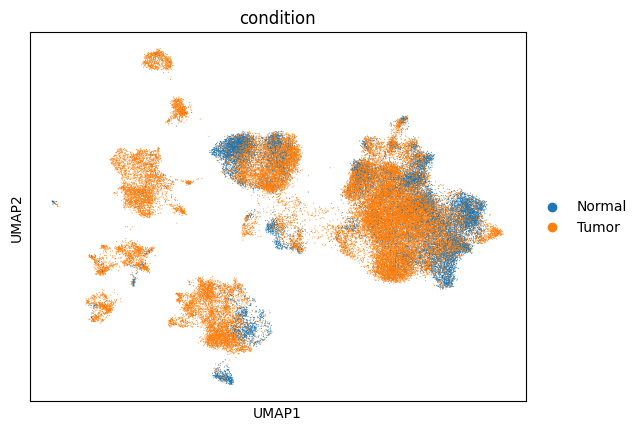

In [28]:
np.random.seed(1)
ri = np.random.permutation(list(range(adata.shape[0])))

sc.pl.umap(adata[ri,:], color = ['condition'], vmin = .5, size = 2)

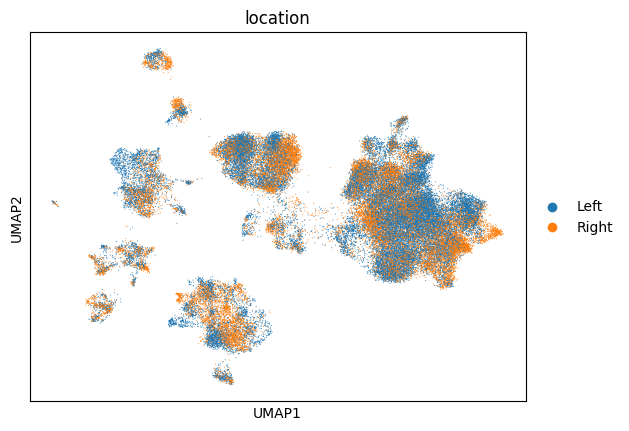

In [29]:
sc.pl.umap(adata[ri,:], color = ['location'], vmin = .5, size = 2)

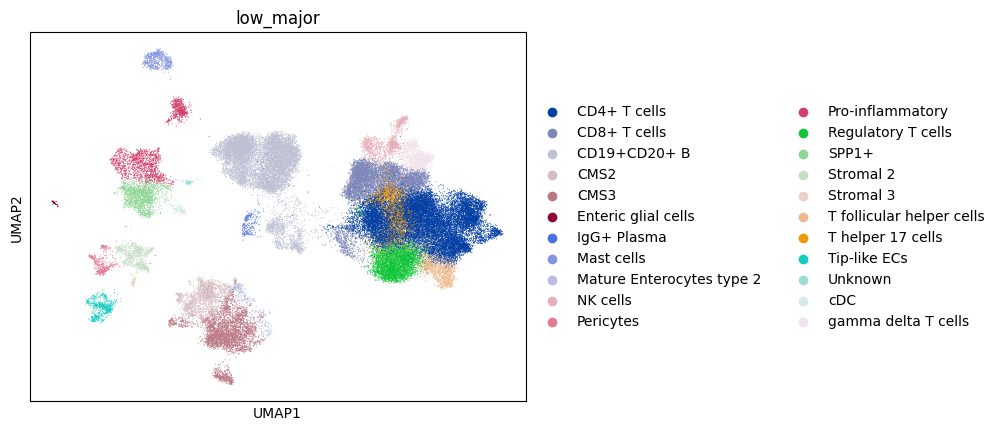

In [31]:
sc.pl.umap(adata[ri,:], color = ['low_major'], vmin = .5, size = 2)

In [32]:
for x in range(len(adata.obs.overcluster.unique())) :
    print(f'"{x}":"",')

"0":"",
"1":"",
"2":"",
"3":"",
"4":"",
"5":"",
"6":"",
"7":"",
"8":"",
"9":"",
"10":"",
"11":"",
"12":"",
"13":"",
"14":"",
"15":"",
"16":"",
"17":"",
"18":"",
"19":"",
"20":"",
"21":"",
"22":"",
"23":"",
"24":"",
"25":"",
"26":"",
"27":"",
"28":"",
"29":"",
"30":"",
"31":"",
"32":"",
"33":"",
"34":"",
"35":"",
"36":"",
"37":"",
"38":"",
"39":"",
"40":"",
"41":"",
"42":"",
"43":"",
"44":"",
"45":"",
"46":"",
"47":"",
"48":"",


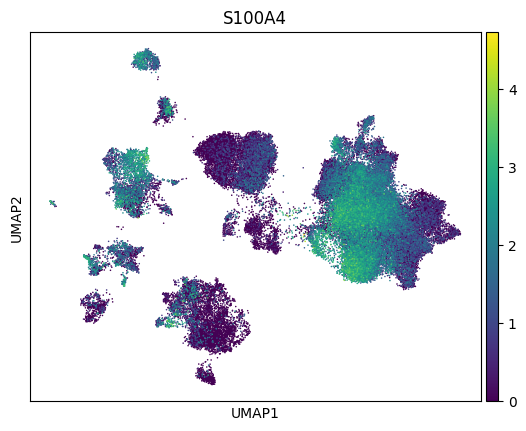

In [34]:
sc.pl.umap(adata, color = ['S100A4'], legend_loc = 'on data', s = 5)